# Experiments with the Dueling DQN algorithm

Implementation from here:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
np.set_printoptions(suppress=True)
import math
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pprint import pprint


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Let's use the same network architecture as for the [Cart-Pole](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) example. However, we need to increase the parameter number to accommodate for the increased state and action space. 

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

In [4]:
def mask_state(state):
    '''
        Since the state space for all 20 vehicles in the scene is enormous (20*7 = 140) we need to reduce the number drastically
        We will consider only the four closest vehicles for now  
    '''
    return state[:6].flatten()

In [13]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

num_episodes = 500

env = gym.make('highway-fast-v0')

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(mask_state(state))

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
episode_reward = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

The reward function for the `highway-v0` setting is defined as (https://highway-env.readthedocs.io/en/latest/rewards/index.html):

$
    R(s,a) = w_{velo}\frac{v-v_{min}}{v_{max}-v_{min}} - w_{col}~\text{collision}
$

with $v, v_{min}, v_{max}$ being the current, minimal and maximal speed of the vehicle, $w_{velo}$ is the weight of the ego speed in the reward and $w_{col}$ is the weight of a collision of the ego vehicle with another vehicle in the reward.

episode: 0, total reward: 2.746, average_reward: 2.746, length: 3
episode: 1, total reward: 3.499, average_reward: 3.123, length: 4
episode: 2, total reward: 5.946, average_reward: 4.064, length: 6
episode: 3, total reward: 1.749, average_reward: 3.485, length: 2
episode: 4, total reward: 3.153, average_reward: 3.419, length: 3
episode: 5, total reward: 2.813, average_reward: 3.318, length: 3
episode: 6, total reward: 10.684, average_reward: 4.370, length: 13
episode: 7, total reward: 4.630, average_reward: 4.402, length: 5
episode: 8, total reward: 9.769, average_reward: 4.999, length: 14
episode: 9, total reward: 1.848, average_reward: 4.684, length: 2
episode: 10, total reward: 1.800, average_reward: 4.589, length: 2
episode: 11, total reward: 10.397, average_reward: 5.279, length: 13
episode: 12, total reward: 10.863, average_reward: 5.771, length: 13
episode: 13, total reward: 7.217, average_reward: 6.317, length: 8
episode: 14, total reward: 6.046, average_reward: 6.607, length: 

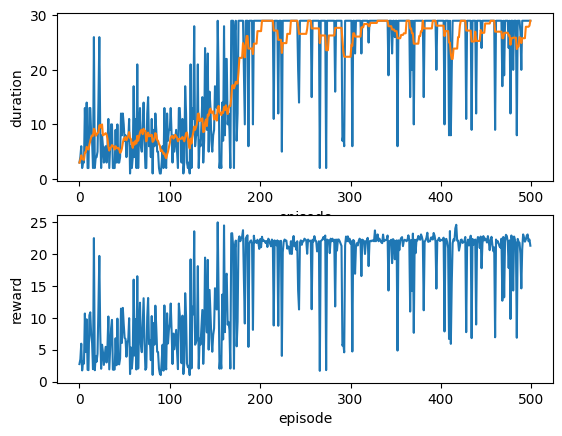

In [15]:
numsteps = []
avg_numsteps = []
all_rewards = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(mask_state(state), dtype=torch.float32, device=device).unsqueeze(0)
    reward_sum = list()
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_sum.append(reward.copy())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(mask_state(observation), dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            numsteps.append(t)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(reward_sum))
            print(f"episode: {i_episode}, total reward: {all_rewards[-1]:.3f}, average_reward: {np.mean(all_rewards[-10:]):.3f}, length: {t}")
            break
        
plt.subplot(2,1,1)
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.ylabel('duration')
plt.xlabel('episode')
plt.subplot(2,1,2)
plt.plot(all_rewards)
plt.ylabel('reward')
plt.xlabel('episode')

plt.show()

We use the target network, which is a momentum based updated version of the policy network for the prediction. It's predictions are more stable

In [16]:
for i_episode in range(50):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(mask_state(state), dtype=torch.float32, device=device).unsqueeze(0)
    MAX_ITERATIONS = 100
    for i in range(MAX_ITERATIONS):
        action = policy_net(state).argmax(1)
        print(f"Action: {list(env.action_type.actions_indexes.keys())[action]}")
        observation, reward, terminated, truncated, _ = env.step(action.item())
        env.render()
        next_state = torch.tensor(mask_state(observation), dtype=torch.float32, device=device).unsqueeze(0)
        # Move to the next state
        state = next_state
        done = terminated or truncated
        if done:
            break
env.close()
    

Action: LANE_RIGHT
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: IDLE
Action: IDLE
Action: IDLE
Action: IDLE
Action: IDLE
Action: IDLE
Action: FASTER
Action: SLOWER
Action: FASTER
Action: SLOWER
Action: FASTER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: LANE_RIGHT
Action: FASTER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER
Action: SLOWER